In [1]:
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt

In [2]:
"""
TODO:
download next dataframe > 24hrs after original (possibly use time.sleep())
produce timestamps of download times
stocks largest % change overall
stocks largest % change by exchange
industries largest % change
sectors largest % change

"""

'\nTODO:\ndownload next dataframe > 24hrs after original (possibly use time.sleep())\nproduce timestamps of download times\nstocks largest % change overall\nstocks largest % change by exchange\nindustries largest % change\nsectors largest % change\n\n'

In [3]:
def convert_to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [4]:
def create_stocks_df():
    combined = pd.DataFrame()
    exchange_names_strings_list = ["nasdaq","nyse","amex"]
    index_list = np.array([])

    for name in exchange_names_strings_list:
        exchange_tickers_url = "http://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=" + \
        name + "&render=download"
        current = pd.read_csv(exchange_tickers_url)
        time.sleep(5) #take 5 seconds to ensure the API will not ban IP address.
        current.loc[:,"exchange"] = name.upper()
        if combined.empty:
            combined = combined.append(current)
        else:
            combined = pd.concat([combined,current])
    
    combined.dropna(axis=1,how="all",inplace=True)
    combined.drop(["Summary Quote","IPOyear"],axis=1,inplace=True)
        
    formatted_columns = [convert_to_snake_case(col) for col in combined.columns]
    combined.columns = formatted_columns
    
    combined.rename({"last_sale":"price"},axis=1,inplace=True)
    combined.reset_index(inplace=True,drop=True)
    
    duplicates_bool = combined.loc[:,"symbol"].duplicated(keep=False)
    duplicates = combined.loc[duplicates_bool,:]
    
    nyse_duplicates_bool = duplicates.loc[:,"exchange"] == "NYSE"
    nasdaq_duplicates_bool = duplicates.loc[:,"exchange"] == "NASDAQ"
    amex_duplicates_bool = duplicates.loc[:,"exchange"] == "AMEX"

    nyse_duplicates_symbols = duplicates.loc[nyse_duplicates_bool,"symbol"]
    nasdaq_duplicates_symbols = duplicates.loc[nasdaq_duplicates_bool,"symbol"]
    amex_duplicates_symbols = duplicates.loc[amex_duplicates_bool,"symbol"]

    amex_in_nasdaq_bool = amex_duplicates_symbols.isin(nasdaq_duplicates_symbols)
    amex_in_nasdaq_true_indexes = (amex_in_nasdaq_bool == True).index.to_list()
    index_list = np.append(index_list,amex_in_nasdaq_true_indexes)

    nasdaq_in_nyse_bool = nasdaq_duplicates_symbols.isin(nyse_duplicates_symbols)
    nasdaq_in_nyse_true_indexes = (nasdaq_in_nyse_bool == True).index.to_list()
    index_list = np.append(index_list,nasdaq_in_nyse_true_indexes)

    index_list = index_list.astype(int)
    combined.drop(index_list,axis=0,inplace=True)
    
    analysis_columns = ["price","market_cap","sector","industry"]
    combined.dropna(axis=0,subset=analysis_columns,inplace=True)
    
    billion_mc = combined.loc[:,"market_cap"].str.contains("B")
    million_mc = combined.loc[:,"market_cap"].str.contains("M")
    
    combined.loc[:,"market_cap"] = combined.loc[:,"market_cap"].str.replace("B","") \
                                                               .str.replace("M","") \
                                                               .str.replace("$","") \
                                                               .astype("float")

    combined.loc[billion_mc,"market_cap"] = combined.loc[billion_mc,"market_cap"] * 1000000000
    combined.loc[million_mc,"market_cap"] = combined.loc[million_mc,"market_cap"] * 1000000
    
    return combined

In [5]:
test = create_stocks_df()

In [6]:
stocks_original = test.copy()

In [7]:
#Uncomment when ready for production

#stocks_original.drop("market_cap",axis=1,inplace=True)

In [8]:
stocks_original.head()

,symbol,name,price,market_cap,sector,industry,exchange
0,YI,"111, Inc.",2.95,2.408900e+08,Health Care,Medical/Nursing Services,NASDAQ
1,PIH,"1347 Property Insurance Holdings, Inc.",5.15,3.097000e+07,Finance,Property-Casualty Insurers,NASDAQ
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.61,1.863000e+07,Finance,Property-Casualty Insurers,NASDAQ
3,TURN,180 Degree Capital Corp.,2.14,6.660000e+07,Finance,Finance/Investors Services,NASDAQ
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.39,1.180000e+09,Consumer Services,Other Specialty Stores,NASDAQ


In [9]:
stocks_later = stocks_original.copy()
stocks_later.drop(["name","sector","industry","exchange"],axis=1,inplace=True)
stocks_later.rename({"price":"new_price",
                     "market_cap":"new_market_cap"},axis=1,inplace=True)

In [10]:
#Remove cell when in production, 'random' is only for testing purposes
stocks_later.loc[:,"new_price"] = round(stocks_later.loc[:,"new_price"] * \
                                       (1.0 + np.random.uniform(-1.0,1.0,size=len(stocks_later.index))),4)
stocks_later.head()

,symbol,new_price,new_market_cap
0,YI,1.7434,2.408900e+08
1,PIH,4.0829,3.097000e+07
2,PIHPP,29.7250,1.863000e+07
3,TURN,2.6354,6.660000e+07
4,FLWS,7.3025,1.180000e+09


In [11]:
stocks_dif = stocks_original.merge(stocks_later,how="inner",on="symbol")
stocks_dif.drop("market_cap",axis=1,inplace=True)
stocks_dif.loc[:,"$_change"] = stocks_dif.loc[:,"new_price"] - stocks_dif.loc[:,"price"]
stocks_dif.loc[:,"%_change"] = (round((stocks_dif.loc[:,"$_change"] / stocks_dif.loc[:,"price"]),4)) * 100
stocks_dif.head()

,symbol,name,price,sector,industry,exchange,new_price,new_market_cap,$_change,%_change
0,YI,"111, Inc.",2.95,Health Care,Medical/Nursing Services,NASDAQ,1.7434,2.408900e+08,-1.2066,-40.90
1,PIH,"1347 Property Insurance Holdings, Inc.",5.15,Finance,Property-Casualty Insurers,NASDAQ,4.0829,3.097000e+07,-1.0671,-20.72
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.61,Finance,Property-Casualty Insurers,NASDAQ,29.7250,1.863000e+07,3.1150,11.71
3,TURN,180 Degree Capital Corp.,2.14,Finance,Finance/Investors Services,NASDAQ,2.6354,6.660000e+07,0.4954,23.15
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.39,Consumer Services,Other Specialty Stores,NASDAQ,7.3025,1.180000e+09,-11.0875,-60.29


In [12]:
def create_weights(df, parameter):
    for dimension in df.loc[:,parameter].unique():
        dimension_bool = df.loc[:,parameter] == dimension
        df.loc[dimension_bool,"mc_"+parameter+"_weight"] = df.loc[dimension_bool,"new_market_cap"] / \
                                                           df.loc[dimension_bool,"new_market_cap"].sum()
        df.loc[dimension_bool,"mc_"+parameter+"_weight_overall"] = df.loc[dimension_bool,"new_market_cap"] / \
                                                                   df.loc[:,"new_market_cap"].sum()
        df.loc[dimension_bool,parameter+"_weighted_%_change"] = df.loc[dimension_bool,"%_change"] * \
                                                                df.loc[dimension_bool,"mc_"+parameter+"_weight"]

In [13]:
parameter_columns = ["sector","industry","exchange"]
for parameter in parameter_columns:
    create_weights(stocks_dif,parameter)

In [14]:
stocks_dif.head()

,symbol,name,price,sector,industry,exchange,new_price,new_market_cap,$_change,%_change,mc_sector_weight,mc_sector_weight_overall,sector_weighted_%_change,mc_industry_weight,mc_industry_weight_overall,industry_weighted_%_change,mc_exchange_weight,mc_exchange_weight_overall,exchange_weighted_%_change
0,YI,"111, Inc.",2.95,Health Care,Medical/Nursing Services,NASDAQ,1.7434,2.408900e+08,-1.2066,-40.90,0.000050,5.778770e-06,-0.002029,0.001589,5.778770e-06,-0.064981,0.000018,5.778770e-06,-0.000721
1,PIH,"1347 Property Insurance Holdings, Inc.",5.15,Finance,Property-Casualty Insurers,NASDAQ,4.0829,3.097000e+07,-1.0671,-20.72,0.000005,7.429470e-07,-0.000113,0.000065,7.429470e-07,-0.001346,0.000002,7.429470e-07,-0.000047
2,PIHPP,"1347 Property Insurance Holdings, Inc.",26.61,Finance,Property-Casualty Insurers,NASDAQ,29.7250,1.863000e+07,3.1150,11.71,0.000003,4.469197e-07,0.000038,0.000039,4.469197e-07,0.000458,0.000001,4.469197e-07,0.000016
3,TURN,180 Degree Capital Corp.,2.14,Finance,Finance/Investors Services,NASDAQ,2.6354,6.660000e+07,0.4954,23.15,0.000012,1.597684e-06,0.000271,0.195750,1.597684e-06,4.531611,0.000005,1.597684e-06,0.000113
4,FLWS,"1-800 FLOWERS.COM, Inc.",18.39,Consumer Services,Other Specialty Stores,NASDAQ,7.3025,1.180000e+09,-11.0875,-60.29,0.000191,2.830731e-05,-0.011516,0.006663,2.830731e-05,-0.401718,0.000086,2.830731e-05,-0.005209


## % Change Z-Score Kernel Density

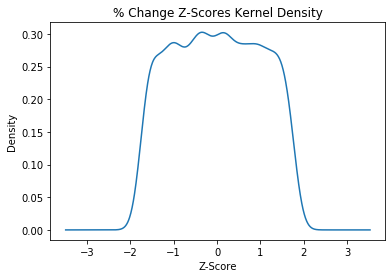

In [15]:
stocks_kd = stocks_dif.copy()
stocks_kd = pd.DataFrame(stocks_kd.loc[:,"%_change"])
stocks_kd.loc[:,"z_score"] = ((stocks_kd.loc[:,"%_change"] - stocks_kd.loc[:,"%_change"].mean()) / stocks_kd.loc[:,"%_change"].std())
stocks_kd.drop("%_change",axis=1,inplace=True)
stocks_kd.plot.density(legend=False)
plt.xlabel("Z-Score")
plt.title("% Change Z-Scores Kernel Density")
plt.show()

## Top Performing Stocks Overall (US)

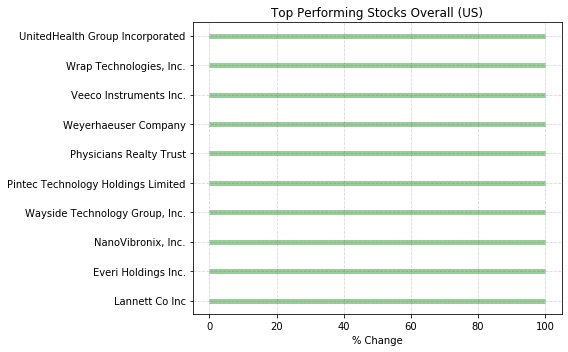

In [16]:
top_stocks = stocks_dif.copy()
top_stocks = top_stocks.loc[:,["name","%_change"]]
top_stocks.sort_values(by="%_change",inplace=True,ascending=False)
top_stocks = top_stocks.head(10)
x_max = top_stocks.loc[:,"%_change"].max()
plt.figure(figsize=(8,5))
plt.hlines(y=top_stocks.name,xmin=0,xmax=x_max,color="green",alpha=0.4, linewidth=5)
plt.gca().set(xlabel="% Change")
plt.title("Top Performing Stocks Overall (US)")
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Worst Performing Stocks Overall (US)

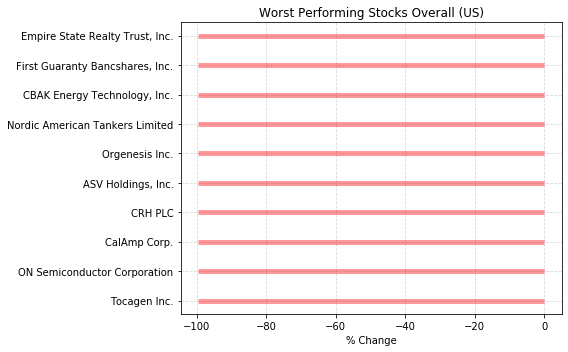

In [17]:
top_stocks = stocks_dif.copy()
top_stocks = top_stocks.loc[:,["name","%_change"]]
top_stocks.sort_values(by="%_change",inplace=True)
top_stocks = top_stocks.head(10)
x_max = top_stocks.loc[:,"%_change"].max()
plt.figure(figsize=(8,5))
plt.hlines(y=top_stocks.name,xmin=0,xmax=x_max,color="red",alpha=0.4, linewidth=5)
plt.gca().set(xlabel="% Change")
plt.title("Worst Performing Stocks Overall (US)")
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
def create_sector_diverging_bars(df,parameter):
    values_name = parameter+"_weighted_%_change"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    group.sort_values(by=values_name,inplace=True)
    
    group.loc[:,"colors"] = ["red" if x < 0 else "green" for x in group.loc[:,values_name]]
    plt.figure(figsize=(8,group.shape[0]/2))
    plt.hlines(y=group.index, xmin=0, xmax=group.loc[:,values_name],color=group.colors, alpha=0.4, linewidth=5)
    plt.gca().set(ylabel=parameter_name, xlabel="% Change")
    plt.title("Performance by "+parameter_name)
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

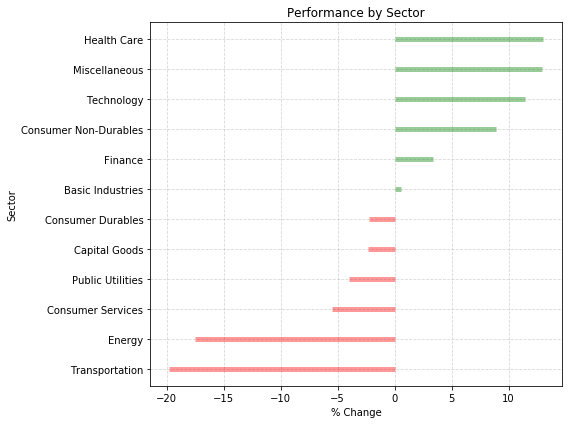

In [19]:
create_sector_diverging_bars(stocks_dif,"sector")

## Best Performing Stocks by Sector

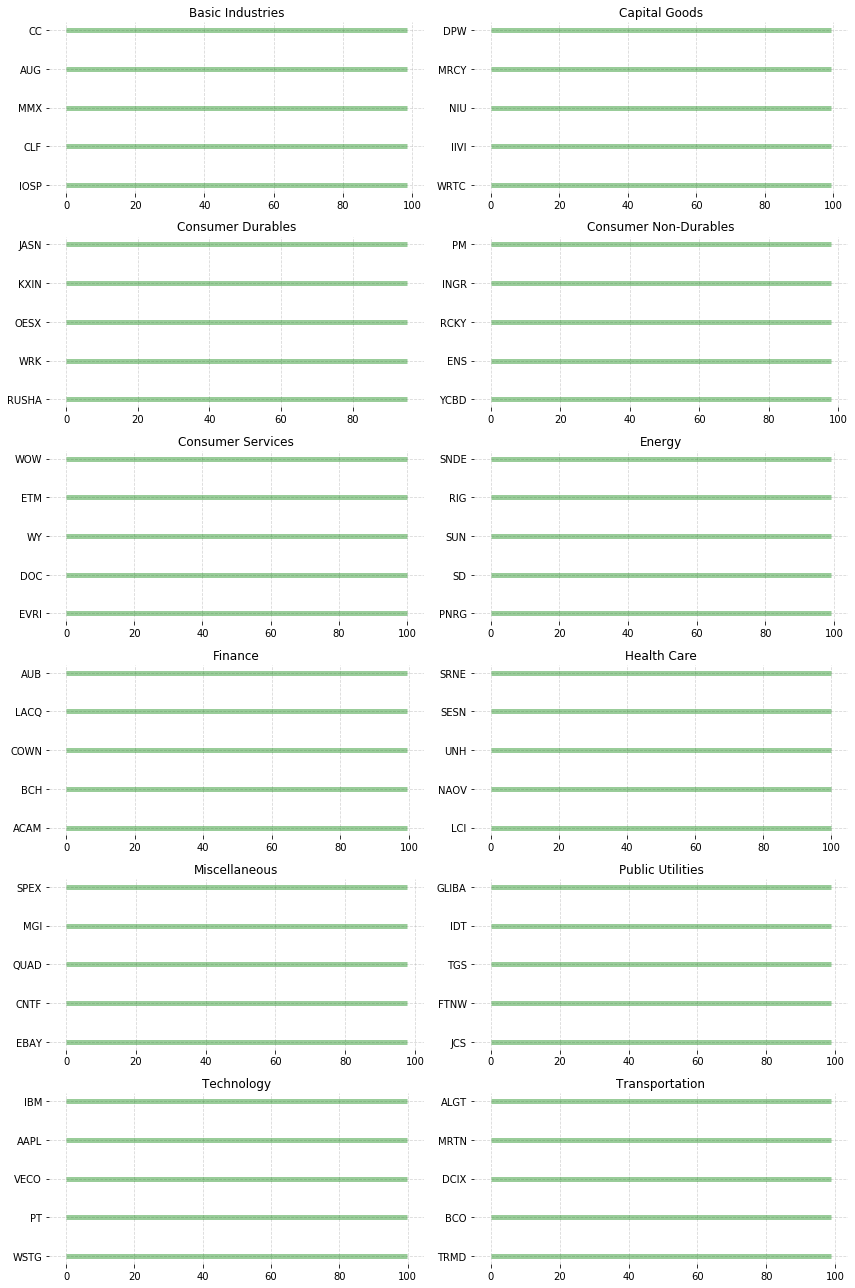

In [20]:
sector_name_group = stocks_dif.copy().loc[:,["symbol","sector","%_change"]].sort_values(by="%_change",ascending=False).groupby("sector")

fig = plt.figure(figsize=(12,18))
frame_index = 1
for group in sector_name_group.groups:
    ax = fig.add_subplot(len(sector_name_group.groups)/2,2,frame_index)
    y_ticks = sector_name_group.get_group(group)["symbol"].head()
    x = sector_name_group.get_group(group)["%_change"].head()
    ax.hlines(y=y_ticks, xmin=0, xmax=x.max(),color="green", alpha=0.4, linewidth=5)
    ax.set_title(group)
    ax.grid(linestyle='--', alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    frame_index += 1

plt.tight_layout()
plt.show()

## Worst Performing Stocks by Sector

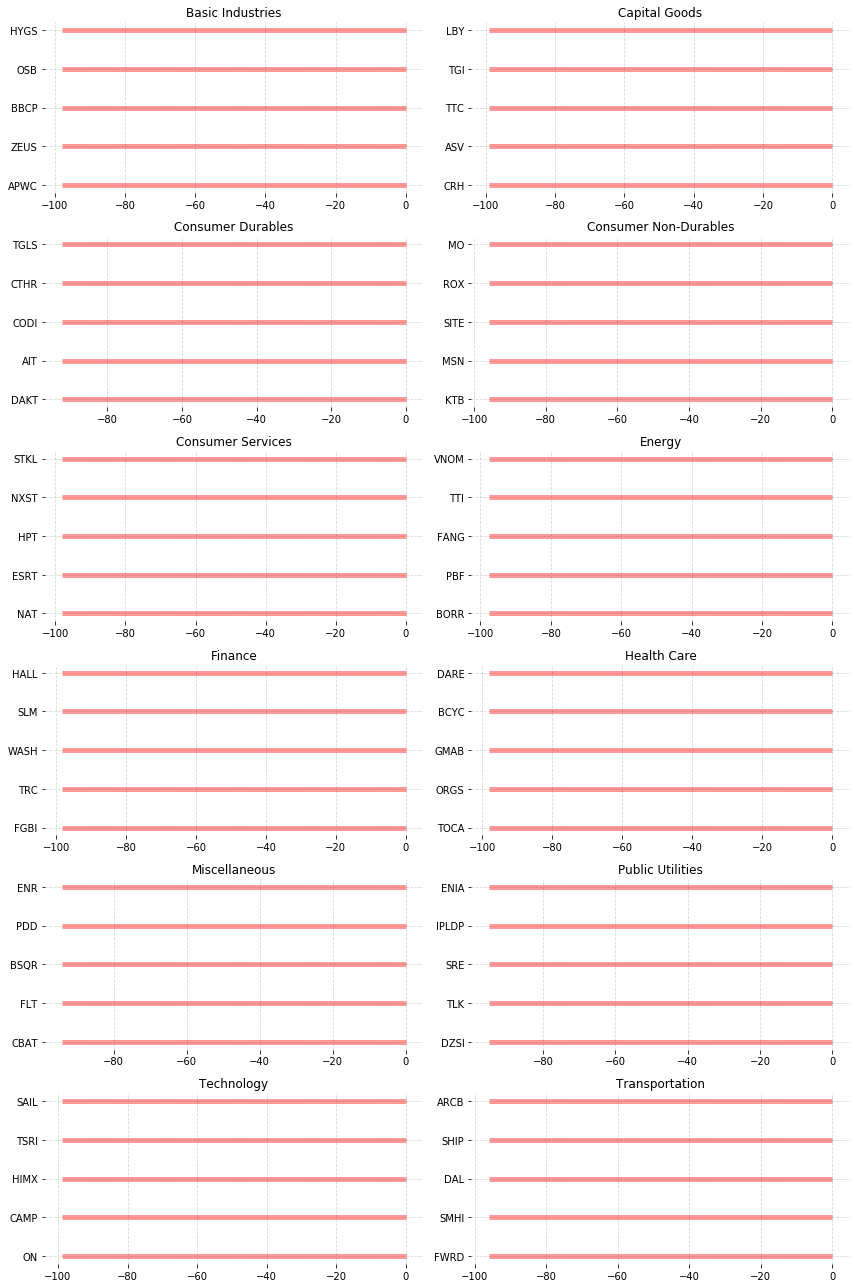

In [21]:
sector_name_group = stocks_dif.copy().loc[:,["symbol","sector","%_change"]].sort_values(by="%_change").groupby("sector")

fig = plt.figure(figsize=(12,18))
frame_index = 1
for group in sector_name_group.groups:
    ax = fig.add_subplot(len(sector_name_group.groups)/2,2,frame_index)
    y_ticks = sector_name_group.get_group(group)["symbol"].head()
    x = sector_name_group.get_group(group)["%_change"].head()
    ax.hlines(y=y_ticks, xmin=0, xmax=x.max(),color="red", alpha=0.4, linewidth=5)
    ax.set_title(group)
    ax.grid(linestyle='--', alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    frame_index += 1

plt.tight_layout()
plt.show()

## Best Performing Stocks by Exchange

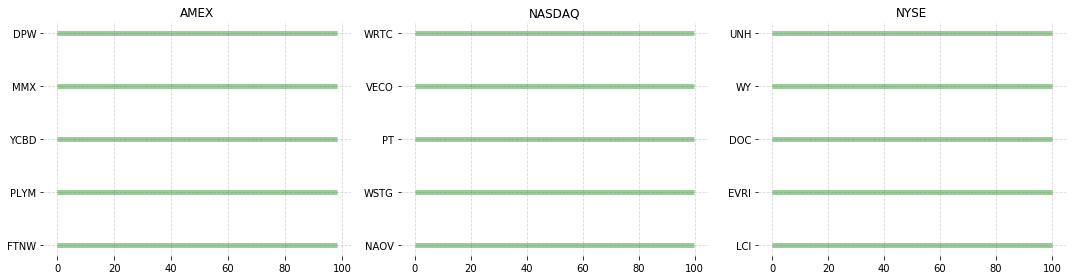

In [22]:
exchange_name_group = stocks_dif.copy().loc[:,["symbol","exchange","%_change"]].sort_values(by="%_change",ascending=False).groupby("exchange")

fig = plt.figure(figsize=(15,4))
frame_index = 1
for group in exchange_name_group.groups:
    ax = fig.add_subplot(1,len(exchange_name_group.groups),frame_index)
    y_ticks = exchange_name_group.get_group(group)["symbol"].head()
    x = exchange_name_group.get_group(group)["%_change"].head()
    ax.hlines(y=y_ticks, xmin=0, xmax=x.max(),color="green", alpha=0.4, linewidth=5)
    ax.set_title(group)
    ax.grid(linestyle='--', alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    frame_index += 1

plt.tight_layout()
plt.show()

## Worst Performing Stocks by Exchange

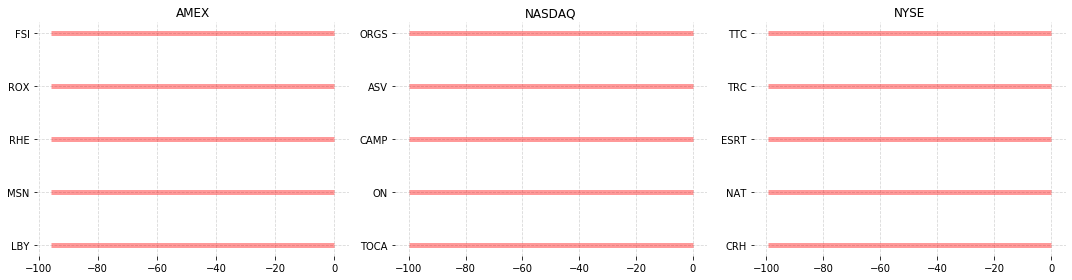

In [23]:
exchange_name_group = stocks_dif.copy().loc[:,["symbol","exchange","%_change"]].sort_values(by="%_change").groupby("exchange")

fig = plt.figure(figsize=(15,4))
frame_index = 1
for group in exchange_name_group.groups:
    ax = fig.add_subplot(1,len(exchange_name_group.groups),frame_index)
    y_ticks = exchange_name_group.get_group(group)["symbol"].head()
    x = exchange_name_group.get_group(group)["%_change"].head()
    ax.hlines(y=y_ticks, xmin=0, xmax=x.max(),color="red", alpha=0.4, linewidth=5)
    ax.set_title(group)
    ax.grid(linestyle='--', alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    frame_index += 1

plt.tight_layout()
plt.show()

In [24]:
def create_group_performance_table(df,parameter,best_or_worst,number):
    values_name = parameter+"_weighted_%_change"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    if best_or_worst == "best":
        group.sort_values(by=values_name,inplace=True,ascending=False)
    else:
        group.sort_values(by=values_name,inplace=True)
    return group.head(number)

In [25]:
create_group_performance_table(stocks_dif,"industry","best",5)

,industry_weighted_%_change
industry,
Computer Manufacturing,89.570590
Medical Electronics,69.609676
Catalog/Specialty Distribution,68.169066
Precision Instruments,65.960000
Consumer Specialties,61.156625


In [26]:
create_group_performance_table(stocks_dif,"industry","worst",5)

,industry_weighted_%_change
industry,
Tools/Hardware,-99.550000
Pollution Control Equipment,-94.330542
Consumer: Greeting Cards,-82.220000
Finance/Investors Services,-69.669275
Biotechnology: In Vitro & In Vivo Diagnostic Substances,-62.492422


In [27]:
def create_pie_chart(df,parameter):
    values_name = "mc_"+parameter+"_weight_overall"
    parameter_name = parameter.capitalize()
    df_copy = df.copy()
    group = df_copy.loc[:,[parameter,values_name]].groupby(parameter).sum()
    group.plot(kind='pie', subplots=True, figsize=(8, 8),legend=False,autopct='%1.1f%%')
    plt.title(parameter_name+"s Comprising US Stock Market by Market Cap.")
    plt.ylabel("")
    plt.show()

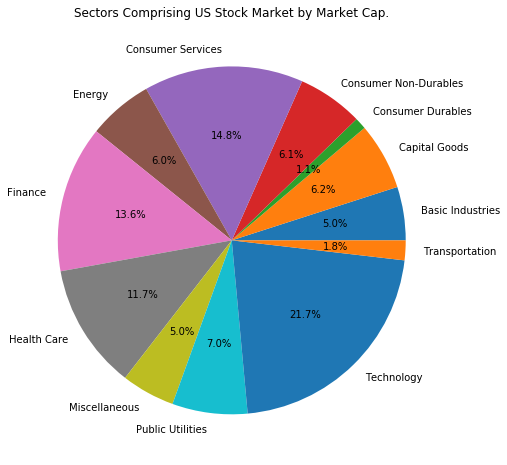

In [28]:
create_pie_chart(stocks_dif,"sector")

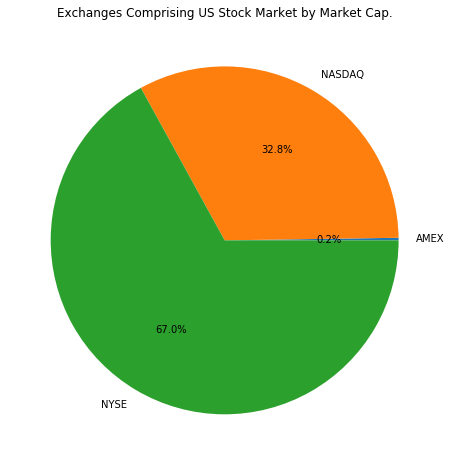

In [29]:
create_pie_chart(stocks_dif,"exchange")